# Policy Gradient Algorithms

## 一、简介

本书之前介绍的Q-learning、DQN 及 DQN 改进算法都是基于价值（value-based）的方法，
其中 Q-learning是处理有限状态的算法，而 DQN 可以用来解决连续状态的问题。

在强化学习中，除了基于值函数的方法，还有一种非常经典的方法，那就是基于策略（policy-based）的方法。


对比两者，基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略( $a=max_{a'}Q(s,a')$ )，
学习过程中并不存在一个显式的策略；而基于策略的方法则是直接显式地学习一个目标策略。

策略梯度是基于策略的方法的基础，本章从策略梯度算法说起。

## 二、策略梯度

基于策略的方法首先需要将策略参数化。

假设目标策略$\pi_\theta$是一个随机性策略，并且处处可微，
其中$\theta$是对应的参数。

我们可以用一个线性模型或神经网络模型来为这样一个策略函数建模，
输入某个状态，然后输出一个动作的概率分布。

我们的目标是寻找一个最优策略并最大化这个策略在环境中的期望回报。

基于策略的方法首先需要将策略参数化。

假设目标策略$\pi_\theta$是一个随机性策略，并且处处可微，
其中$\theta$是对应的参数。

我们可以用一个线性模型或神经网络模型来为这样一个策略函数建模，
输入某个状态，然后输出一个动作的概率分布。

我们的目标是寻找一个最优策略并最大化这个策略在环境中的期望回报。

我们将策略学习的目标函数定义为:

$J(\theta)=E_{s_0}[V^{\pi_\theta}(s_0)]$

然后是对这个目标函数的求梯度，好长一串，先记住，日后再补充

**TODO: Prove the gradient**

<img src="./media/img.png" style="zoom:60%;">
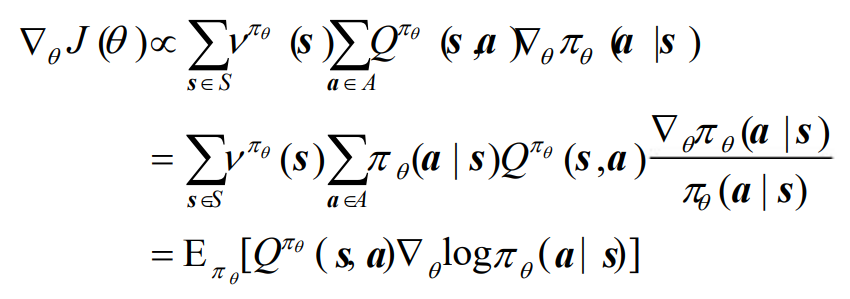

这个梯度可以用来更新策略。

需要注意的是，因为上式中期望E 的下标是$\pi_\theta$，所以策略梯
度算法为在线策略（on-policy）算法，即必须使用当前策略$\pi_\theta$采样得到的数据来计算梯度。

直观理解策略梯度这个公式，可以发现在每一个状态下，
梯度的修改是让策略更多地采样到带来较高Q值的动作，
更少地采样到带来较低Q值的动作

在计算策略梯度的公式中，我们需要用到$Q^{\pi_\theta}(s,a)$，
可以用多种方式对它进行估计。

接下来要介绍的 REINFORCE 算法便采用了蒙特卡洛方法来估计$Q^{\pi_\theta}(s,a)$，
对一个有限步数的环境来说，REINFORCE 算法中的策略梯度为：

<img src="./media/img_1.png" style="zoom:60%;">

## 三、REINFORCE

In [5]:
import gymnasium as gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from Hands_on_RL_Note import rl_utils
from Hands_on_RL_Note.chapter9_PG.Policy_Net import PolicyNet

In [6]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer= torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate) # 使用 Adam 优化器
        self.gamma = gamma # 折扣因子
        self.device = device

    def take_action(self, state): # 根据动作概率分布随机采样
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))): # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = - log_prob * G # 每一步的损失函数
            loss.backward() # 反向传播计算梯度
        self.optimizer.step() # 梯度下降

PS：

1、这里的 take action 是按照 Categorical 分布采样动作的，而不是选取概率最大的动作，是为了兼顾策略的探索性和利用性。

2、在 update 函数中，我们是从后往前计算每一步的回报 G 的，因为 G 的计算是依赖于下一步的 G 的。

3、update 函数中，具体公式还待推导，这里先放着，后续补充。

In [7]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset(seed=0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes/10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state, _ = env.reset()
            terminated, truncated = False, False
            while not (terminated or truncated):
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode+1) % 10 == 0:
                pbar.set_postfix(
                    {
                        'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                     }
                )
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s, episode=1000, return=400.200]


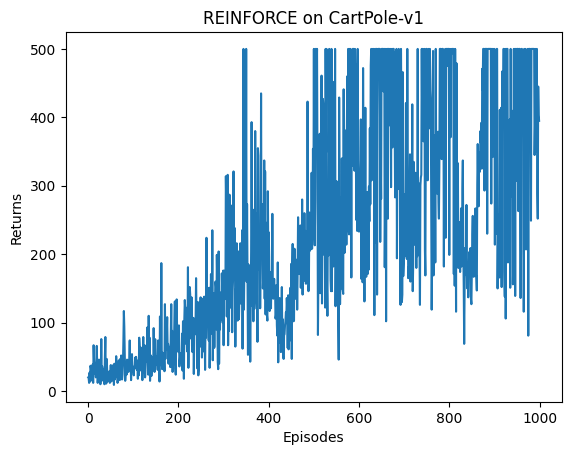

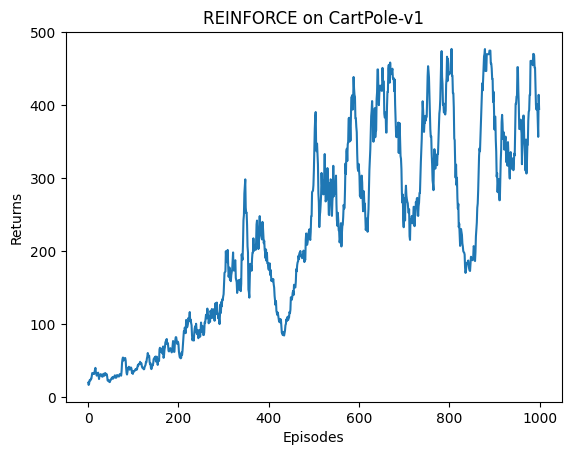

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

## 简单总结

### 1、算法差异

之前的算法是 value base 的，无论是mtc，td，q learning 还是 dqn，都是先学值函数，然后根据值函数导出策略。
策略的选择可能是贪婪的，也可能是 epsilon 贪婪的。

### 2、工作流程

#### 第一步：初始概率 —— 随机初始化的网络 “瞎猜”

策略网络（PolicyNet）初始化时，所有参数是随机的，
此时输出的动作概率完全是 “乱猜”，没有任何依据。

举例（CartPole 环境）：

初始状态\(s_0\)（小车位置 0、速度 0、杆角度 0、角速度 0）传入网络：

此时网络完全不知道 “向左（动作 0）” 或 “向右（动作 1）” 哪个更好，概率只是随机数经softmax归一化的结果（保证和为 1）。

#### 第二步：概率更新 —— 用「回报」告诉网络 “哪个动作好”

网络通过 “试错” 收集轨迹，用折扣回报$G_t$作为 “好坏信号”，调整参数让 “带来高回报的动作” 概率升高。